# 5.Visualization

Generating plots in "Neural predictors of fear depend on the situation"

Preprint at https://www.biorxiv.org/content/10.1101/2022.10.20.513114v1

*Yiyu Wang 2022 Jan*

In [14]:
import glob
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib
import warnings

# stats
from scipy import linalg, ndimage, stats
from scipy.stats import norm

# nifti handling
from nilearn.input_data import NiftiMasker
from nilearn import decoding
from nilearn.masking import apply_mask, intersect_masks
from nilearn import image
from nilearn.image import new_img_like, load_img, get_data, concat_imgs, mean_img,math_img
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from nilearn import surface

# nilearn mask:
from nilearn.datasets import load_mni152_gm_mask,load_mni152_wm_mask,fetch_surf_fsaverage


# plotting modules
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_prob_atlas, plot_img, show
from nilearn.image import threshold_img
from nilearn.plotting import plot_roi
from nilearn import surface
fsaverage = fetch_surf_fsaverage()

warnings.filterwarnings('ignore')

In [15]:
permutation_test_res_dir = 'results/permutation_test/'

mask_dir = 'masks/'
bg_img = mask_dir + 'MNI152_T1_1mm_brain.nii.gz'


my_color_three = ['#1f77b4', '#9edae5', '#EF2D2E']
color_padding_three =['#1f77b4', '#9edae5','#D3D3D3','#D3D3D3']
my_cmap_three = matplotlib.colors.ListedColormap(color_padding_three + my_color_three)

# my_color_seven = ['#42AC65','#9C6CC7', '#F39C12']
my_color_seven = ['#33a02c', '#6a3d9a', '#ff7f00', '#b2df8a', '#FDF85E', '#DA83F8', '#EF2D2E']
color_padding = ["#fd7f6f", "#7eb0d5", "#ffee65", "#b2e061", "#bd7ebe", "#ffb55a","#8bd3c7",'#D3D3D3']
my_cmap_seven = matplotlib.colors.ListedColormap(color_padding + my_color_seven)

vmin = 0.01



# Figure 2: Situation-by-Situation Model

In [17]:
# load the breakdown
overlay = nib.load(permutation_test_res_dir + 'SS_overlay_byNum.nii.gz')
overlay_by_sit = nib.load(permutation_test_res_dir + 'SS_overlay_bySit.nii.gz')

## Figure 2a.

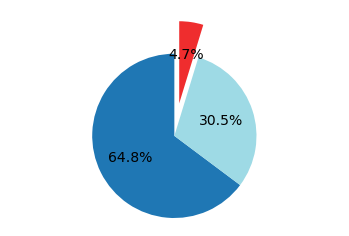

In [5]:
overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent', 'Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Figure 2b

### Create surface texture for surface plot

We will create the overlay by each image because vol_to_surf treats numbers as intensity while the numbers are categories here.


In [6]:
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)


texture_threshold = 0.7


texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0)
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)



sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1


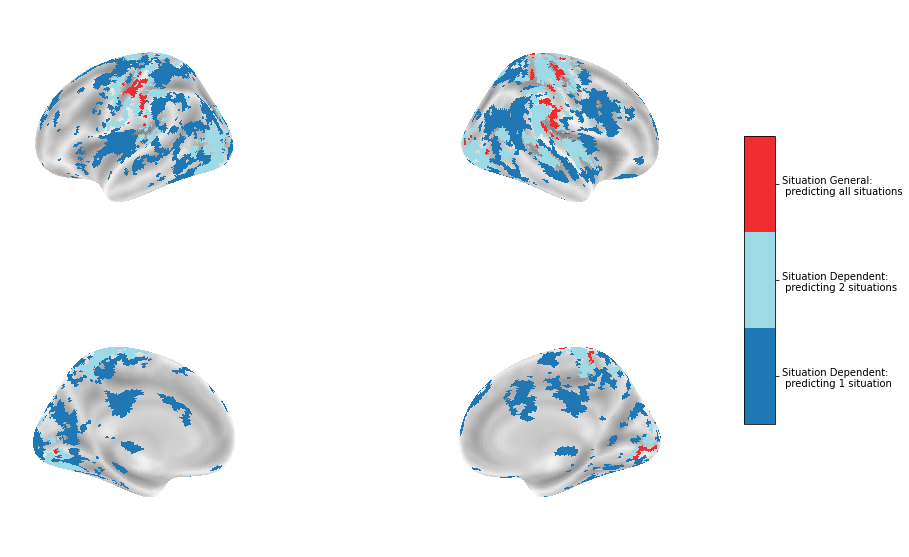

In [7]:
# plot the results:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=0, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


# Figure 2C.

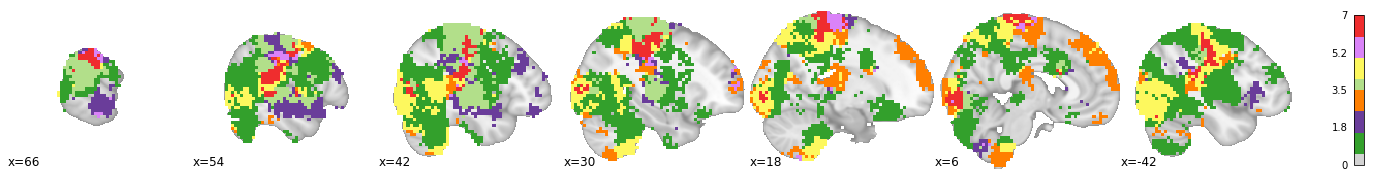

In [8]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)



# Figure 1: Across Situation Model

In [18]:
# load the results

overlay =nib.load(permutation_test_res_dir + 'AS_overlay_byNum.nii.gz')
overlay_by_sit = nib.load(permutation_test_res_dir + 'AS_overlay_bySit.nii.gz')

## Figure 1a

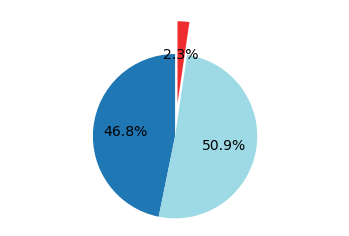

In [10]:
overlay_data = overlay.get_fdata()

one = np.sum(overlay_data==1)
two = np.sum(overlay_data==2)
three = np.sum(overlay_data==3)


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Situation dependent:1', '2.Situation dependent:2', 'Situation General'
labels = ' ', ' ', ' '
sizes = [one, two, three]
explode = (0, 0, 0.4)  # only "explode" the 3nd slice - Situation General

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90, colors = my_color_three)
ax1.axis('equal')

plt.show()


## Figure 1b


In [11]:
# binarize the img
One_only =  math_img('img1 == 1', img1 = overlay)
Two_only =  math_img('img1 == 2', img1 = overlay)
Three_only =  math_img('img1 == 3', img1 = overlay)

# since suface rendering is a probablistic interpolation, set a threshold for binarizing:
texture_threshold = 0.7

texture_right1 = surface.vol_to_surf(One_only, fsaverage.pial_right, interpolation='nearest')
texture_left1 = surface.vol_to_surf(One_only, fsaverage.pial_left, interpolation='nearest')
texture_right1 = np.where(texture_right1>texture_threshold, 1, 0) 
texture_left1 = np.where(texture_left1>texture_threshold, 1, 0)

texture_right2 = surface.vol_to_surf(Two_only, fsaverage.pial_right, interpolation='nearest')
texture_left2 = surface.vol_to_surf(Two_only, fsaverage.pial_left, interpolation='nearest')
texture_right2 = np.where(texture_right2>texture_threshold, 2, 0)
texture_left2 = np.where(texture_left2>texture_threshold, 2, 0)

texture_right3 = surface.vol_to_surf(Three_only, fsaverage.pial_right, interpolation='nearest')
texture_left3 = surface.vol_to_surf(Three_only, fsaverage.pial_left, interpolation='nearest')
texture_right3 = np.where(texture_right3>texture_threshold, 3, 0)
texture_left3 = np.where(texture_left3>texture_threshold, 3, 0)

# combine the three 
sum_texture_right = texture_right3 + texture_right2 + texture_right1
sum_texture_left = texture_left3 + texture_left2 + texture_left1

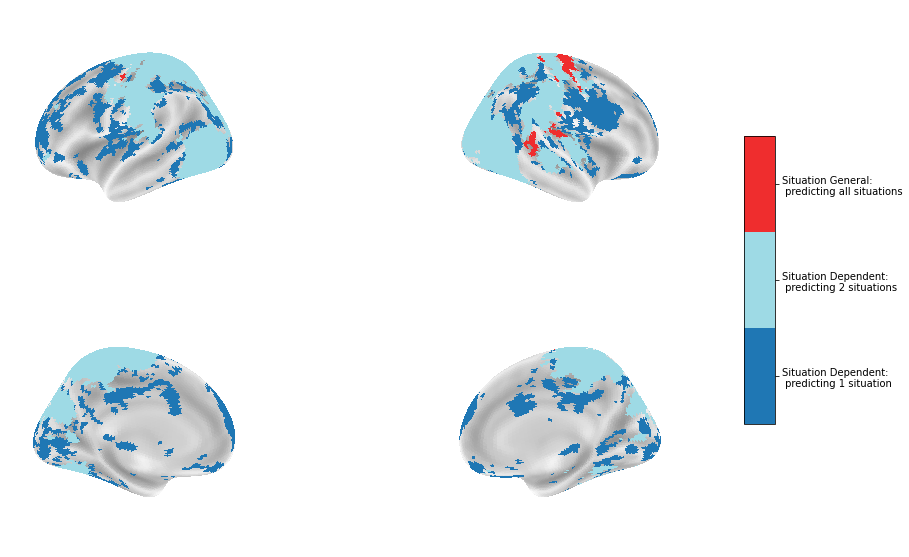

In [12]:
# Surface plot:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14,10), subplot_kw={'projection': '3d'})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='lateral', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3, vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[0,0], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='lateral', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax =3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_right, axes=ax[0,1], darkness = 0.5, inflate=True)


plotting.plot_surf(fsaverage.infl_left, sum_texture_left,view='medial', hemi='left',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin,vmin=-3,vmax = 3,avg_method='median',cbar_vmin=0, cbar_vmax=3,
                            bg_map=fsaverage.sulc_left,axes=ax[1,0], darkness = 0.5, inflate=True)

plotting.plot_surf(fsaverage.infl_right, sum_texture_right,view='medial', hemi='right',
                            colorbar=False, cmap=my_cmap_three, threshold=vmin, vmin=-3,vmax =3,cbar_vmin=0, cbar_vmax=3,
                           avg_method='median',
                            bg_map=fsaverage.sulc_right,axes=ax[1,1], darkness = 0.5, inflate=True)


cmap = matplotlib.colors.ListedColormap(my_color_three)
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5, 2.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
# cbar_ax.set_yticklabels(["Situation Dependent", "Situation Dependent", "Situation General"])
cbar_ax.set_yticklabels(["Situation Dependent: \n predicting 1 situation", "Situation Dependent: \n predicting 2 situations", "Situation General: \n predicting all situations"])

plt.show()


## Figure 1c

### plot brain slices:

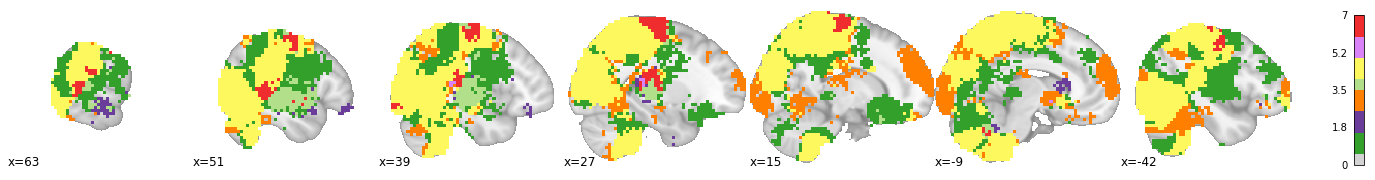

In [13]:
plotting.plot_stat_map(overlay_by_sit, cmap=my_cmap_seven, display_mode='x', vmax=7,bg_img=bg_img,black_bg=False)